In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, SGDClassifier
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset


In [2]:
# Logistic Regression Model
class LogisticRegressionModel(nn.Module):
    def __init__(self, input_dim):
        super(LogisticRegressionModel, self).__init__()
        self.linear = nn.Linear(input_dim, 1)

    def forward(self, x):
        outputs = torch.sigmoid(self.linear(x))
        return outputs

In [3]:
layer = 8

In [3]:
generated_answer_log_probs_mean_test = np.load("ckpts/sft_ctrex_llama7B_2_commit_lr1e-5_2/checkpoint_30000/hf_model/generated_answer_log_probs_mean_test.npy")
hidden_states_test = np.load("ckpts/ppo_ctrex_llama7B_commit35_idk10/best_checkpoint/hf_model/hidden_states_test.npy")

In [11]:
hidden_states_test[8].shape

(249250, 4096)

In [9]:
train_idxs = np.random.choice(len(generated_answer_log_probs_mean_test), int(0.8*len(generated_answer_log_probs_mean_test)), replace=False)
test_idxs = np.array([i for i in range(len(generated_answer_log_probs_mean_test)) if i not in train_idxs])


In [10]:


mean = np.mean(hidden_states_test[layer], axis=0)


X = hidden_states_test[layer]-mean

y = np.exp(generated_answer_log_probs_mean_test)

X_train = X[train_idxs]
y_train = y[train_idxs]

X_test = X[test_idxs]
y_test = y[test_idxs]

In [22]:


# Assuming X_train and y_train are your data and labels as PyTorch tensors
X_train = torch.tensor(X_train)  # Replace with your data
y_train = torch.tensor(y_train)  # Replace with your labels

X_test = torch.tensor(X_test)  # Replace with your data
y_test = torch.tensor(y_test)  # Replace with your labels

# Create Dataset
train_data = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)

# Model, Loss Function, and Optimizer
input_dim = X_train.shape[1]
model = LogisticRegressionModel(input_dim)
criterion = nn.BCELoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

# Train the Model
num_epochs = 10
for epoch in range(num_epochs):
    for i, (inputs, labels) in enumerate(train_loader):
        # Forward pass
        outputs = model(inputs.float())
        loss = criterion(outputs, labels.float().view(-1, 1))

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')



/tmp/ipykernel_20006/925623199.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train = torch.tensor(X_train)  # Replace with your data
/tmp/ipykernel_20006/925623199.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(y_train)  # Replace with your labels
/tmp/ipykernel_20006/925623199.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_test = torch.tensor(X_test)  # Replace with your data
/tmp/ipykernel_20006/925623199.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTenso

Epoch [10/10], Loss: 0.3586


In [26]:
# Model Evaluation
# Assuming you have X_test and y_test tensors for evaluation
model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    y_predicted = model(X_test.float())
    y_predicted_cls = y_predicted.round()
    y_test = y_test.round()

    accuracy = y_predicted_cls.eq(y_test.float().view_as(y_predicted_cls)).sum() / float(y_test.shape[0])
    print(f'Accuracy: {accuracy:.4f}')

    loss = criterion(y_predicted, y_test.float().view(-1, 1))
    print(f'Loss: {loss:.4f}')

Accuracy: 0.9923
Loss: 0.1913


In [40]:
np.save("ckpts/ppo_ctrex_llama7B_commit35_idk10/best_checkpoint/hf_model/linear_regression_train_mean.npy", mean)
torch.save(model.state_dict(), "ckpts/ppo_ctrex_llama7B_commit35_idk10/best_checkpoint/hf_model/linear_regression_train_weights.pt")

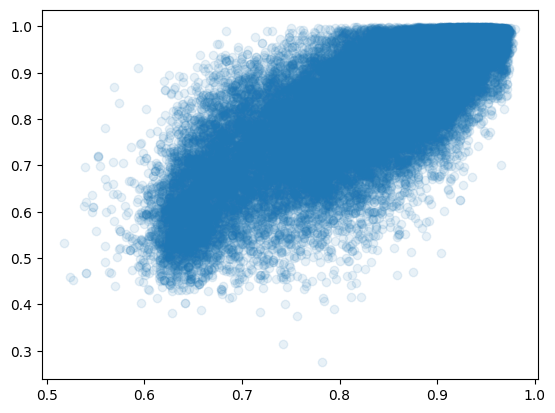

In [31]:
plt.plot(y_predicted.detach().numpy(), y[test_idxs], 'o', alpha=0.1)
plt.savefig("fig.png")

In [4]:
generation_categories_ood = np.load("ckpts/ppo_ctrex_llama7B_commit35_idk10/best_checkpoint/hf_model/generation_categories.npy")
hidden_states_ood = np.load("ckpts/ppo_ctrex_llama7B_commit35_idk10/best_checkpoint/hf_model/hidden_states_ood.npy")
generated_answer_log_probs_mean_ood = np.load("ckpts/sft_ctrex_llama7B_2_commit_lr1e-5_2/checkpoint_30000/hf_model/generated_answer_log_probs_mean_ood.npy")


In [5]:
hidden_states_ood = hidden_states_ood[layer]

In [8]:
mean = np.load("ckpts/ppo_ctrex_llama7B_commit35_idk10/best_checkpoint/hf_model/linear_regression_train_mean.npy")
rand_idxs = np.random.choice(len(generated_answer_log_probs_mean_ood), int(0.1*len(generated_answer_log_probs_mean_ood)), replace=False)


X_ood = (hidden_states_ood-mean)[rand_idxs]
y_ood = np.exp(generated_answer_log_probs_mean_ood)[rand_idxs]

input_dim = X_ood.shape[1]
model = LogisticRegressionModel(input_dim)
model.load_state_dict(torch.load("ckpts/ppo_ctrex_llama7B_commit35_idk10/best_checkpoint/hf_model/linear_regression_train_weights.pt"))

<All keys matched successfully>

In [9]:

X_ood = torch.tensor(X_ood)
y_ood = torch.tensor(y_ood)  # Replace with your labels


ood_data = TensorDataset(X_ood, y_ood)
ood_loader = DataLoader(ood_data, batch_size=64, shuffle=False)

In [10]:


model.eval()  # Set the model to evaluation mode

y_predicted = np.zeros(len(y_ood))
for i, (inputs, labels) in enumerate(ood_loader):

    
    # Forward pass
    outputs = model(inputs.float())
    y_predicted[i*64:(i+1)*64] = outputs.detach().numpy().squeeze()

In [11]:
y_predicted.shape

(31157,)

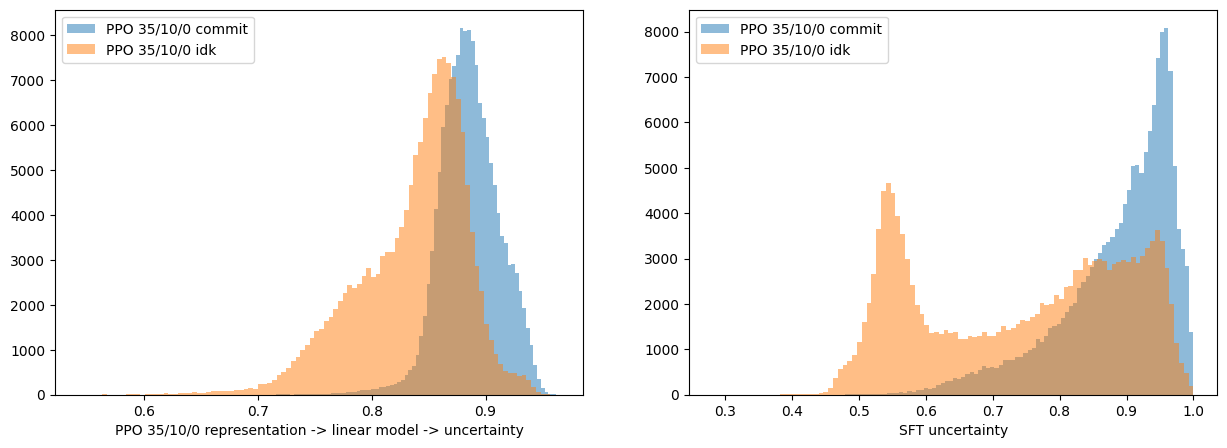

In [19]:
commit_idxs = np.where(generation_categories_ood[:, 3] == 0)[0]
idk_idxs = np.where(generation_categories_ood[:, 3] == 1)[0]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.hist(y_predicted[commit_idxs], bins=100, alpha=0.5, label="PPO 35/10/0 commit")
ax1.hist(y_predicted[idk_idxs], bins=100, alpha=0.5, label="PPO 35/10/0 idk")
ax1.legend()
ax1.set_xlabel("PPO 35/10/0 representation -> linear model -> uncertainty")


ax2.hist(np.exp(generated_answer_log_probs_mean_ood)[commit_idxs], bins=100, alpha=0.5, label="PPO 35/10/0 commit")
ax2.hist(np.exp(generated_answer_log_probs_mean_ood)[idk_idxs], bins=100, alpha=0.5, label="PPO 35/10/0 idk")
ax2.legend()
ax2.set_xlabel("SFT uncertainty")



plt.savefig("fig.png")

(0.8, 1.0)

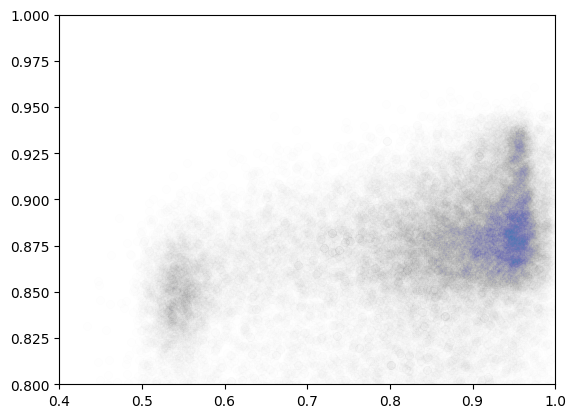

In [17]:
plt.scatter(np.exp(generated_answer_log_probs_mean_ood[rand_idxs]), y_predicted, alpha=0.005)
plt.xlim(0.4, 1)
plt.ylim(0.8, 1)

# plt.savefig("fig.png")